# **Análise de risco quantitativa para escolha da melhor carteira de projetos**

## **Problema a ser resolvido**

Em posse de uma lista priorizada de projetos de obras de engenharia com suas respectivas estimativas preliminares de custo e sabendo o histórico de verba disponível ano a ano, quantas dessas demandas será possível executar?

## **Introdução**

Em organizações que gerenciam múltiplos projetos simultâneos, a escassez de recursos financeiros torna-se um desafio central para a tomada de decisão. No contexto aqui tratado, essa questão se expressa na necessidade de equilibrar o orçamento anual destinado a obras de infraestrutura com a demanda reprimida de intervenções necessárias, de modo a garantir que os projetos de maior prioridade sejam executados sem comprometer o desempenho institucional. Oscilações orçamentárias anualizadas observadas em dados históricos, introduzem incertezas que dificultam a simples aplicação de métodos determinísticos ou de heurísticas estáticas.

Parte-se de uma lista de projetos priorizada contendo as estimativas de custo necessárias para executar cada obra. Almeja-se definir o ponto de corte dassa lista que minimize o risco de sobrar ou faltar recursos para atender as demandas. A imagem abaixo ilustra as carteiras viáveis.

<p align="center">
  <img src='https://raw.githubusercontent.com/labrego-scp/portfolio/main/carteira_menor_risco/img/carteiras.jpg' width='600'><br>
  <em>Figura 1: Carteiras possíveis</em>
</p>

De um lado, temos o custo da carteira, que contrasta com a capacidade orçamentária da instituição. Na carteira temos a estimativa preliminar de custo. Para se chegar ao custo de fato, elabora-se um projeto de engenharia, que refina a estimativa de custo. Para se chegar ao valor final, devemos aguardar a conclusão da obra. Entre o valor real e a estimativa inicial, que é que temos disponível na fase de planejamento, incidem 2 fatores de incerteza: projeto x ecp e obra x projeto. Com relação à capacidade orçamentária, existe uma previsão, sobre a qual incide um fator de incerteza. Existem mapeados todo o histórico desses fatores de incerteza, de tal forma que é possível, variando-se as incertezas, calcular a razão entre o custo final e a capacidade orçamentária real para i cenários distintos, usando a expressão abaixo:

$$
\rho^{i} = \frac{\sum_{p=1}^{n} C^{p} \cdot \left(1 + \delta^{i,p}_{\text{proj-ECP}}\right) \cdot \left(1 + \delta^{i,p}_{\text{obra-proj}}\right)}{O_{\text{esperado}} \cdot \left(1 + \delta^{i}_{\text{orçamento}}\right)}
$$
Onde:
- existem i cenários,
- a carteira possui n projetos,
- $ C^{p} $ é a estimativa de custo preliminar (ECP) da carteira de projetos,
- $ \delta^{i,p}_{\text{proj-ECP}} $ é a incerteza inerente às variações entre projetos e ECPs,
- $ \delta^{i,p}_{\text{obra-proj}} $ é a incerteza inerente às variações entre obras e projetos,
- $ O_{\text{esperado}} $ é o orçamento esperado, e
- $ \delta^{i}_{\text{orçamento}} $ é a incerteza inerente às variações entre o orçamento real e o previstos.

Nota: os $ \delta $ 's são gerados aleatoriamente com base na distribuição de frequência obtida por meio dos dados históricos.

Dificilmente a razão $ \rho^{i} $ resultará em 100%, devido às variações inerentes ao problema. Portanto, a metodologia exige do tomador de decisão a determinação de um intervalo de tolerância percentual para essa razão. A imagem abaixo faz uma analogia desse intervalo de tolerância com um alvo.

<p align="center">
  <img src='https://raw.githubusercontent.com/labrego-scp/portfolio/main/carteira_menor_risco/img/intervalo.jpg' width='600'><br>
  <em>Figura 2: Ilustração do intervalo de tolerância</em>
</p>

Para cada carteira possível serão realizadas $ n_{rep} $ repetições, gerando i cenários diferentes. Para cada cenário será calculado o valor de $ \rho^{i} $ . A carteira que gerar a maior quantidade de $ \rho^{i} $ 's dentro do intervalo de tolerância pré-definido será considerada a carteira de menor risco orçamentário. Essa proporção de $ \rho^{i} $ 's em relação ao total de simulações será denominada $ r_{Budget} $.

Para lidar com essa complexidade, este notebook apresenta uma abordagem baseada no Método de Monte Carlo, integrando simulações estocásticas a um framework de seleção de carteiras de projetos. A metodologia segue seis etapas principais:
1) Importações e carregamento dos dados
2) Análise dos dados de entrada
3) Discretização dos dados históricos
4) Criação dos cenários com o método de Monte Carlo e escolha da solução com menor risco.
5) Análise estatística da solução adotada.
6) Conclusões

## **1. Importações e carregamento dos dados**

In [1]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import matplotlib.ticker as mticker

# Carga dos dados
df_var_etp_prj = pd.read_excel('https://raw.githubusercontent.com/labrego-scp/portfolio/main/carteira_menor_risco/inputs/1-etp_x_projeto.xlsx')
df_var_etp_prj = pd.read_excel('https://raw.githubusercontent.com/labrego-scp/portfolio/main/carteira_menor_risco/inputs/1-etp_x_projeto.xlsx')
df_var_prj_obr = pd.read_excel('https://raw.githubusercontent.com/labrego-scp/portfolio/main/carteira_menor_risco/inputs/2-projeto_x_obra.xlsx')
df_available_budget = pd.read_excel('https://raw.githubusercontent.com/labrego-scp/portfolio/main/carteira_menor_risco/inputs/3-orc_disponivel.xlsx')
df_list = pd.read_excel('https://raw.githubusercontent.com/labrego-scp/portfolio/main/carteira_menor_risco/inputs/6-lista_projetos.xlsx')

## **2. Análise dos dados de entrada**

### **2.1  Explorando as variações históricas**

In [2]:
# Transformando todos os IDs em 'object'
df_var_etp_prj['ID'] = df_var_etp_prj['ID'].astype(str)
df_var_prj_obr['ID'] = df_var_prj_obr['ID'].astype(str)
df_list['ID'] = df_list['ID'].astype(str)

# Conhecendo o DataFrame da variação histórica  entre os valores estimados no Estudo Técnico Preliminar
# e os valores após a elaboração do Projeto Executivo
print('Conhecendo o DataFrame da variação histórica  entre os valores estimados no Estudo Técnico Preliminar ' \
'e os valores após a elaboração do Projeto Executivo')
print(df_var_etp_prj.info())
print(df_var_etp_prj.head())
print(df_var_etp_prj.describe())

Conhecendo o DataFrame da variação histórica  entre os valores estimados no Estudo Técnico Preliminar e os valores após a elaboração do Projeto Executivo
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     74 non-null     object 
 1   VALOR ESTIMATIVA (R$)  74 non-null     float64
 2   VALOR PROJETO (R$)     74 non-null     float64
 3   VARIAÇÃO               74 non-null     float64
dtypes: float64(3), object(1)
memory usage: 2.4+ KB
None
     ID  VALOR ESTIMATIVA (R$)  VALOR PROJETO (R$)  VARIAÇÃO
0  1992             6946776.34          5555042.24   -0.2003
1  1994             1200000.00           863977.96   -0.2800
2  1998              870000.00          1014287.23    0.1658
3  1999             3840000.00          2925338.24   -0.2382
4  2000             2210000.00          1980304.31   -0.1039
       VA

In [3]:

# Conhecendo o Dataframe da variação histórica  entre os valores após a elaboração do Projeto Executivo e
# os valores finais das Obras
print('Conhecendo o DataFrame da variação histórica  entre os valores após a elaboração do Projeto Executivo e ' \
'os valores finais das Obras')
df_var_prj_obr.info()
df_var_prj_obr.head()
df_var_prj_obr.describe()


Conhecendo o DataFrame da variação histórica  entre os valores após a elaboração do Projeto Executivo e os valores finais das Obras
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  140 non-null    object 
 1   VALOR PROJETO (R$)  140 non-null    float64
 2   VALOR OBRA (R$)     140 non-null    float64
 3   VARIAÇÃO            140 non-null    float64
dtypes: float64(3), object(1)
memory usage: 4.5+ KB


,VALOR PROJETO (R$),VALOR OBRA (R$),VARIAÇÃO
count,1.400000e+02,1.400000e+02,140.000000
mean,3.413214e+06,3.227544e+06,-0.084058
std,8.201509e+06,8.324296e+06,0.199552
min,2.907971e+04,2.393140e+04,-0.816200
25%,3.604697e+05,3.175622e+05,-0.177275
50%,1.046506e+06,9.371586e+05,-0.074900
75%,3.177774e+06,3.206996e+06,-0.000575
max,7.356278e+07,7.356278e+07,0.658900


Verificando se existem valores ausentes nos DataFrames

In [4]:
# Função que verifica se existem valores ausentes em um DataFrame
def verify_null(data):
    cols_with_na = []
    for col in data.columns:
        if data[col].isna().sum()>0:
            cols_with_na.append(col)
    if len(cols_with_na)>0:
        return True, cols_with_na
    return False, cols_with_na

# Dicionário criado para iterações
dict_df = {'variação de valor entre o ETP e o Projeto Executivo': df_var_etp_prj,
           'variação de valor entre o Projeto Executivo e a Obra Concluída': df_var_prj_obr,
           'variação do orçamento anual disponível': df_available_budget}
# Verificação de valores ausentes nos DataFrames de dados históricos
for key, value in dict_df.items():
    has_null, list_null = verify_null(value)
    if not has_null:
        print(f'Não existem valores ausentes no DataFrame de {key}.')
    else:
        print(f'As colunas {list_null} possuem valores ausentes no Dataframe de {key}.')


Não existem valores ausentes no DataFrame de variação de valor entre o ETP e o Projeto Executivo.
Não existem valores ausentes no DataFrame de variação de valor entre o Projeto Executivo e a Obra Concluída.
Não existem valores ausentes no DataFrame de variação do orçamento anual disponível.


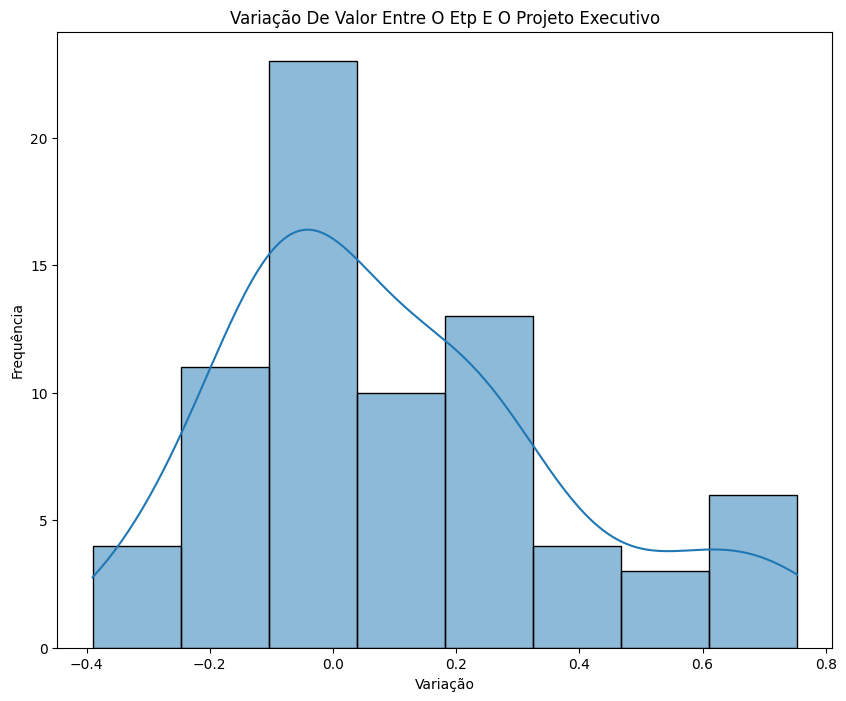

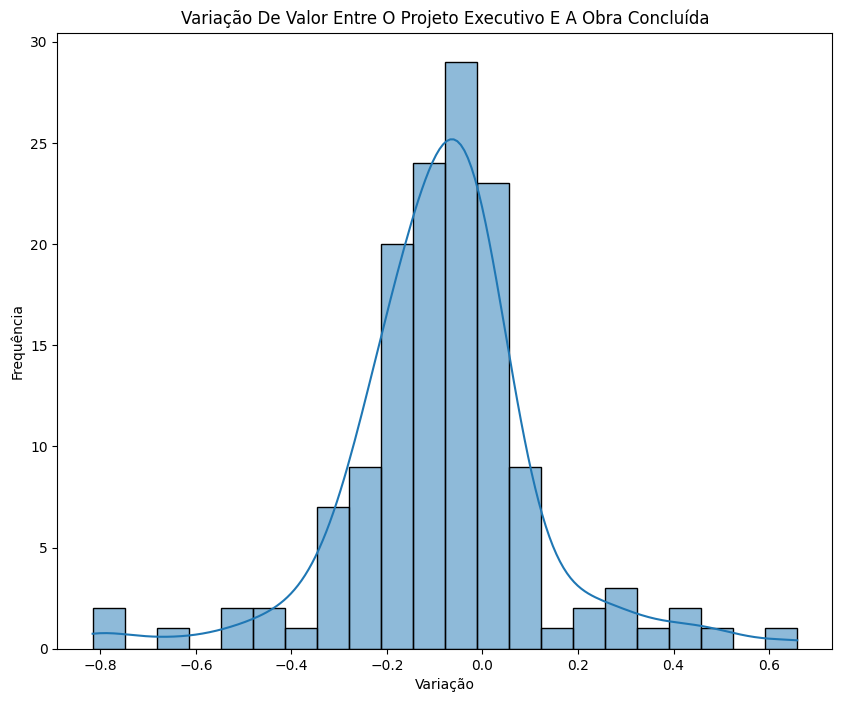

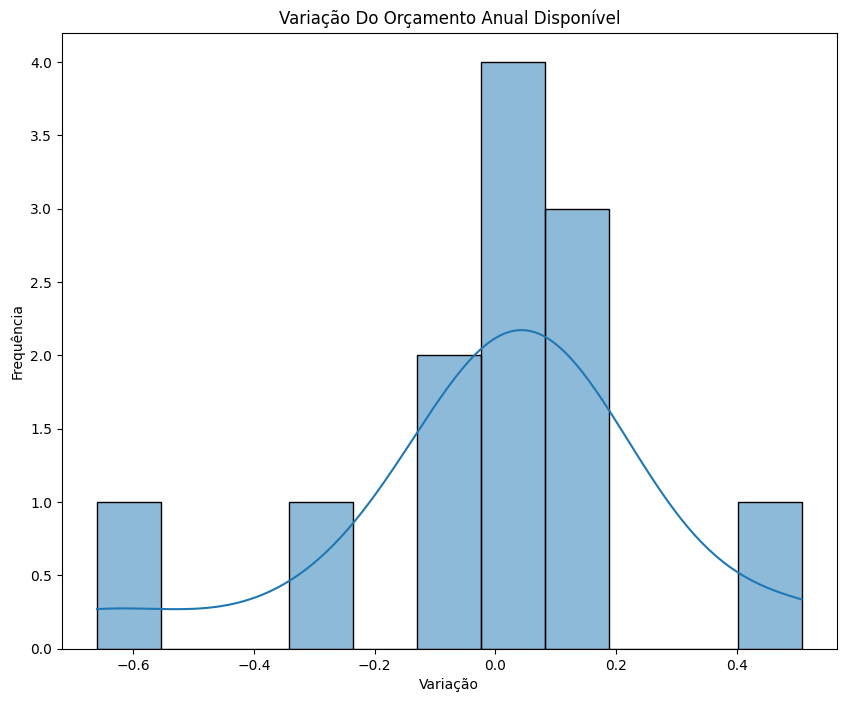

In [5]:
# Plotando o histograma
# Função que plota o histograma
def create_hist(data, x, title, xlabel, ylabel):
    plt.figure(figsize=(10,8))
    sns.histplot(data = data, x=x, kde=True)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

# Chamada da função de criação dos histogramas
for key, value in dict_df.items():
    create_hist(value,'VARIAÇÃO', key.title(), 'Variação', 'Frequência')
    print('')


Deve-se verificar se há outliers. Para isso será usado o método IQR.

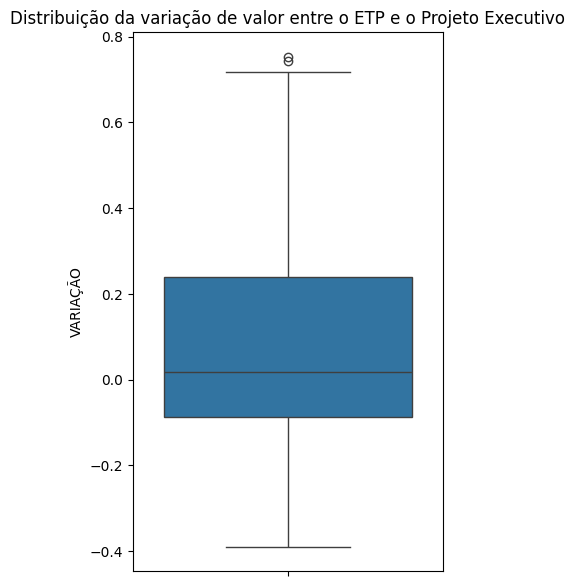

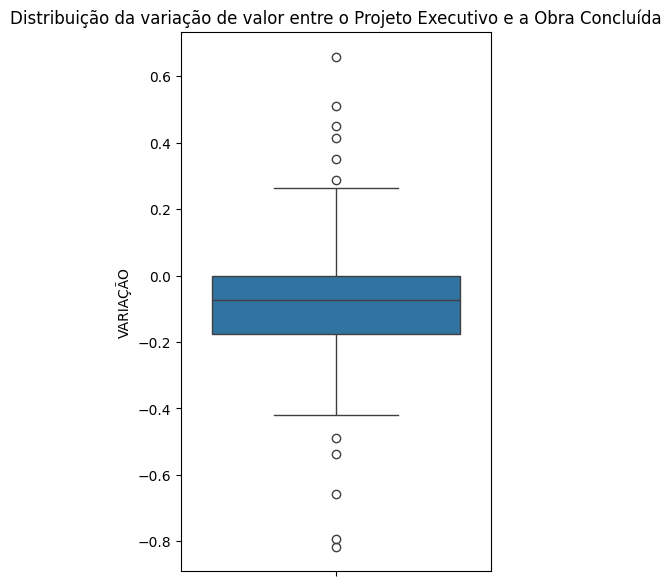

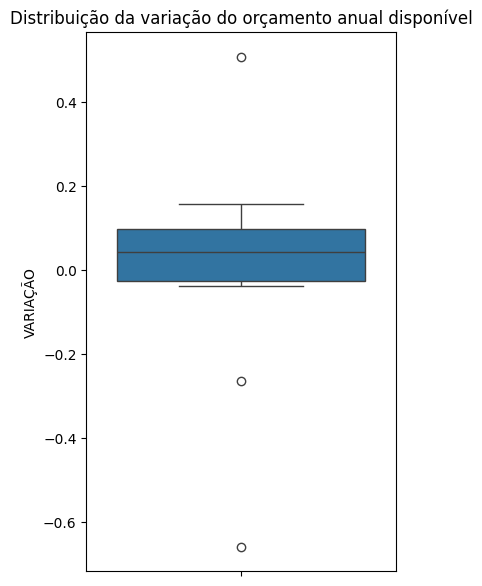


Há 2 outliers no DataFrame de variação de valor entre o ETP e o Projeto Executivo.
Como o número de outliers no DataFrame de variação de valor entre o ETP e o Projeto Executivo representa menos de que 5% do total da amostra, opta-se por excluir esses outliers
Há 11 outliers no DataFrame de variação de valor entre o Projeto Executivo e a Obra Concluída.
Como o número de outliers no DataFrame de variação de valor entre o Projeto Executivo e a Obra Concluída representa mais de que 5% do total da amostra, opta-se por não excluir esses outliers. Deverá ser pensada outra alternativa
Há 3 outliers no DataFrame de variação do orçamento anual disponível.
Como o número de outliers no DataFrame de variação do orçamento anual disponível representa mais de que 5% do total da amostra, opta-se por não excluir esses outliers. Deverá ser pensada outra alternativa


In [6]:
# Definindo uma função para verificar se há outliers
# Função que verifica a existência de outliers
def verify_outlier(data):
    iqr = data.quantile(0.75) - data.quantile(0.25)
    lower_bound = data.quantile(0.25) - iqr*1.5
    upper_bound = data.quantile(0.75) + iqr*1.5
    n_outliers = 0
    for item in data:
        if item > upper_bound or item < lower_bound:
            n_outliers += 1
    if n_outliers > 0:
        return True, n_outliers
    return False, ''

# Visualizando os outliers dos DataFrames de variação histórico por meio de boxplots
for key, value in dict_df.items():
    plt.figure(figsize=(4,7))
    sns.boxplot(data=value, y='VARIAÇÃO')
    plt.title(f'Distribuição da {key}')
    plt.show()
    print('')

# Verificando outliers DataFrames de variação histórico por meio da função criada acima
for key, value in dict_df.items():
    has_outlier, n_outliers = verify_outlier(value['VARIAÇÃO'])
    if has_outlier:
        print(f'Há {n_outliers} outliers no DataFrame de {key}.')
        if n_outliers <= 0.05*len(value['VARIAÇÃO']):
            print(f'Como o número de outliers no DataFrame de {key}' \
            ' representa menos de que 5% do total da amostra, opta-se por excluir esses outliers')
        else:
            print(f'Como o número de outliers no DataFrame de {key}' \
            ' representa mais de que 5% do total da amostra, opta-se por não excluir esses outliers. Deverá ser pensada outra alternativa')
    else:
        print('Não há outliers no DataFrame de {key}.')


Seguindo a proposta apresentada, os outliers do DataFrame de variação entre o projeto e o ETP são eliminados.

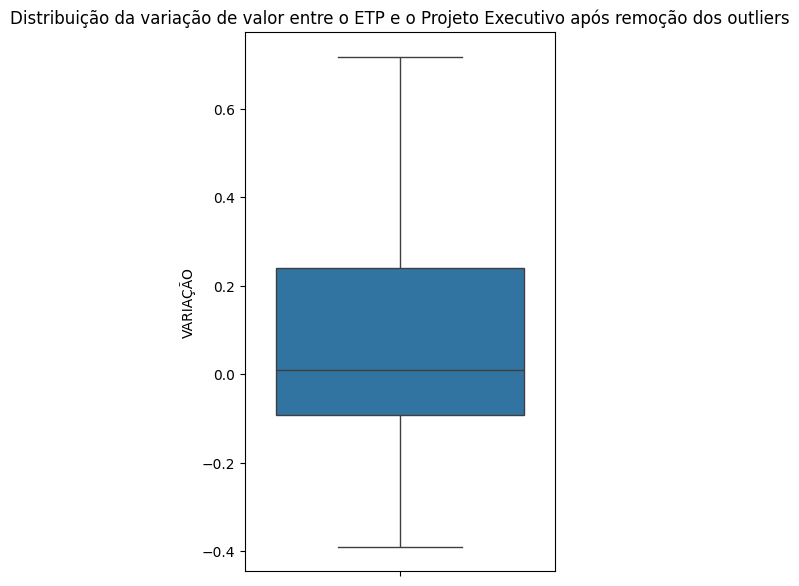

In [7]:
# Definindo uma função para remover outliers
def remove_outliers(data, col):
    iqr = data[col].quantile(0.75) - data[col].quantile(0.25)
    lower_bound = data[col].quantile(0.25) - iqr*1.5
    upper_bound = data[col].quantile(0.75) + iqr*1.5
    for index, row in data.iterrows():
        if row[col] > upper_bound or row[col] < lower_bound:
            data.drop(index, inplace=True)

remove_outliers(df_var_etp_prj, 'VARIAÇÃO')

plt.figure(figsize=(4,7))
sns.boxplot(data=df_var_etp_prj, y='VARIAÇÃO')
plt.title('Distribuição da variação de valor entre o ETP e o Projeto Executivo' \
' após remoção dos outliers')
plt.show()



Os outliers da variação entre o valor da obra e o projeto exigem um tratamento específico para evitar a perda excessiva de dados relevantes na análise.

De acordo com o art. 59, §4º da Lei 14.133/2021, propostas com valor inferior a **75%** do orçamento da Administração (neste caso, o Projeto Executivo) são consideradas inexequíveis. Além disso, a mesma lei permite supressões unilaterais de até **50%**.

Com base nisso, será adotado como limite inferior de corte de outliers a variação de **-62,5%**, calculada por:

$$
(0.75 * 0.5) - 1 = -0.625
$$

Para o limite superior, considera-se que acréscimos, no caso de reformas, não podem ultrapassar **50%**, conforme o mesmo dispositivo legal. Portanto, esse será o valor adotado como corte superior para outliers.

In [8]:
# Verificando a quantidade de linhas a remover do DataFrame de variação entre a obra e o projeto
upper_bound = 0.5
lower_bound = -0.625
n_outliers = df_var_prj_obr[(df_var_prj_obr['VARIAÇÃO'] > upper_bound) | (df_var_prj_obr['VARIAÇÃO'] < lower_bound)].shape[0]


if n_outliers <= 0.05*len(df_var_prj_obr['VARIAÇÃO']):
    print('Como o número de outliers no DataFrame de variação entre a obra e o projeto' \
    'representa menos de que 5% do total da amostra, opta-se por excluir esses outliers')
else:
    print('Como o número de outliers no DataFrame de variação entre a obra e o projeto ' \
    'representa mais de que 5% do total da amostra, opta-se por não excluir esses outliers. Deverá ser pensada outra alternativa')

Como o número de outliers no DataFrame de variação entre a obra e o projetorepresenta menos de que 5% do total da amostra, opta-se por excluir esses outliers


Segundo o novo método de definição de outliers para o DataFrame de variação entre a obra e o projeto, serão excluídos os valores superiores a 50% e inferiores a -62,5%.

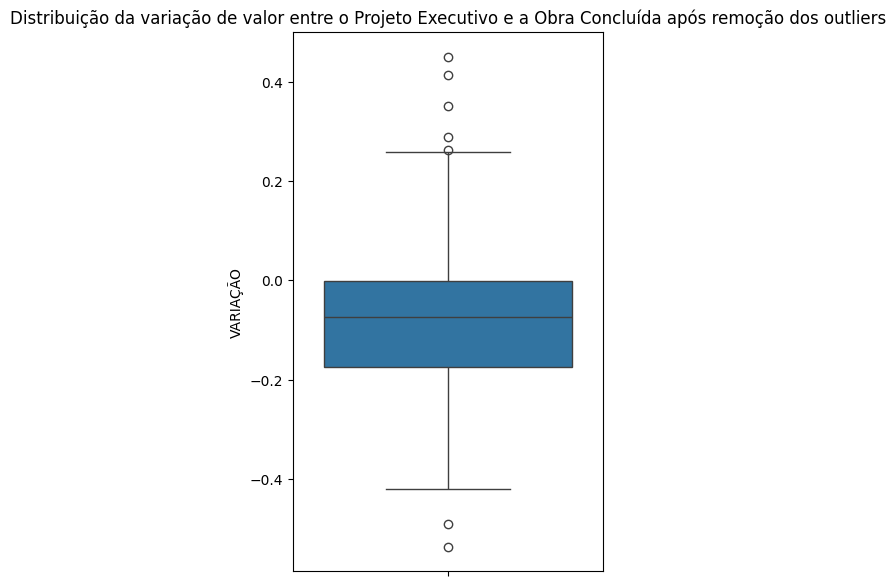

In [9]:
# Definindo uma função para remover outliers conforme limites definidos a partir da Lei 14.133
def remove_outliers_law(data, col):
    lower_bound = -0.625
    upper_bound = 0.5
    for index, row in data.iterrows():
        if row[col] > upper_bound or row[col] < lower_bound:
            data.drop(index, inplace=True)

remove_outliers_law(df_var_prj_obr, 'VARIAÇÃO')

plt.figure(figsize=(4,7))
sns.boxplot(data=df_var_prj_obr, y='VARIAÇÃO')
plt.title('Distribuição da variação de valor entre o Projeto Executivo e a Obra Concluída' \
' após remoção dos outliers')
plt.show()


Quanto ao DataFrame de variação anual do orçamento disponível, Devido a sua baixa quantidade DE dados e a sua peculiaridade naturalmente aleatória, **não serão removidas observações desse DataFrame**.

### **2.2  Conhecendo a lista de projetos ordenada**

In [10]:
df_list['PRIORIDADE'] = df_list['PRIORIDADE'].astype(str)
print(df_list.info())
print('')
print(df_list.head())

# Estatísticas descritivas
print(df_list.describe())

# Verificando se há algum valor ausente
if df_list.isnull().values.any():
    print('Há valores ausentes no DataFrame de lista priorizada de projetos.')
else:
    print('Não há valores ausentes no DataFrame de lista priorizada de projetos.')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PRIORIDADE             34 non-null     object 
 1   ID                     34 non-null     object 
 2   VALOR ESTIMATIVA (R$)  34 non-null     float64
dtypes: float64(1), object(2)
memory usage: 948.0+ bytes
None

  PRIORIDADE    ID  VALOR ESTIMATIVA (R$)
0          1  2093             5658426.41
1          2  2096             3078523.81
2          3  2097             3078169.43
3          4  2165             1000000.00
4          5  2101              300785.28
       VALOR ESTIMATIVA (R$)
count           3.400000e+01
mean            1.945818e+06
std             2.250933e+06
min             3.148859e+04
25%             4.559788e+05
50%             9.374232e+05
75%             2.837620e+06
max             8.499061e+06
Não há valores ausentes no DataFrame de lista priorizada de pr

In [11]:
# Plotando a lista de projetos
print(df_list)

   PRIORIDADE    ID  VALOR ESTIMATIVA (R$)
0           1  2093             5658426.41
1           2  2096             3078523.81
2           3  2097             3078169.43
3           4  2165             1000000.00
4           5  2101              300785.28
5           6  2102              283984.25
6           7  2103              459417.88
7           8  2104             1520134.40
8           9  2106             1142879.95
9          10  2108               31488.59
10         11  2109              226611.57
11         12  2110              136784.96
12         13  2113              454832.38
13         14  2114             1529571.87
14         15  2100             8499061.10
15         16  2132             4370001.17
16         17  2134              759898.39
17         18  2139             2115970.00
18         19  2140              495065.00
19         20  2146              305178.54
20         21  2155              650000.00
21         22  2148             1510377.49
22         

### **2.3  Definindo o intervalo de tolerância**

Adotou-se um limite inferior porcentual de tolerância de **80%** para o orçamento. Com isso, utiliza-se de quase todo o orçamento disponível sem represar verbas, enquanto uma pequena margem pode permitir a realocação para outras áreas.
O limite superior porcentual de tolerância para o orçamento foi adotado como sendo **110%**. A margem justifica-se devido à possibilidade de uso de fontes adicionais de recursos.

In [12]:
tolerance_interval = (0.8, 1.1)

### **2.4  Definindo o orçamento esperado**

Adotou-se como expectativa de orçamento disponível para o ano em estudo a disponibilidade orçamentária do último ano de forma arredondada: **R$ 40 milhões**.

In [13]:
expec_budget = 40*10**6

### **2.5  Definindo o número de repetições (cenários simulados por carteira)**

Para definição do número de cenários simulados para cada carteira ($ n_{rep} $), cabe salientar que quanto maior seu valor, maior será a precisão do modelo. Entretanto, o custo computacional será superior, seguindo uma tendência linear.

Para determinar o ponto ótimo, será analisada a alteração da variância em função do número de repetições. Considerando que o desvio padrão da proporção de uma amostra com $ n_{rep} $ suficientemente grande segue a equação abaixo, espera-se que a relação gerada seja uma curva de decaimento exponencial. Essa curva permitirá identificar até que ponto o aumento de $n_{rep}$ resultará em ganhos significativos para o modelo. O valor de $n_{rep}$ correspondente ao "joelho" da curva será utilizado como referência.

$$ \text{SD}(\hat{p}) = \sqrt{\frac{\hat{p}(1 - \hat{p})}{n_{\text{rep}}}} $$

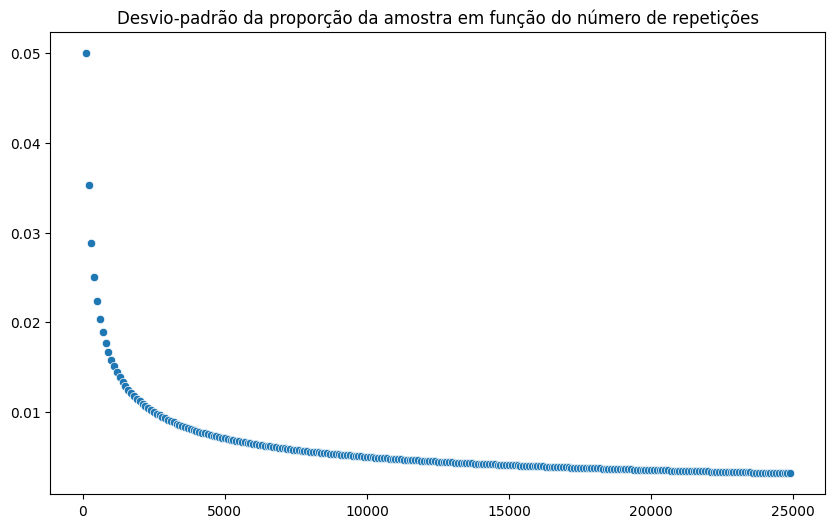

In [14]:
p = 0.5 # probabilidade de sucesso considerada
x = []
y = []
for n_rep in range(100,25000,100):
    x.append(n_rep)
    y.append(np.sqrt(p*(1-p)/n_rep))

plt.figure(figsize=(10,6))
sns.scatterplot(x=x, y=y)
plt.title('Desvio-padrão da proporção da amostra em função do número de repetições')
plt.show()

A partir do gráfico acima, nota-se que valores de $n_{rep}$ superiores a 2.500 já não proporcionam ganhos significativos em termos de redução do desvio padrão estimado. Isso sugere que, além desse ponto, o aumento no número de repetições do algoritmo de Monte Carlo resulta em um custo computacional desproporcional, que cresce linearmente com o número de repetições, aos benefícios obtidos em termos de precisão. Portanto, o valor de $n_{rep}$ igual a **2.500** pode ser considerado um ponto de referência eficiente para alcançar um equilíbrio entre a precisão do modelo e o custo computacional, contribuindo para uma otimização mais eficaz dos recursos no processo de simulação.

In [15]:
n_rep = 2500

## **3. Discretização dos dados históricos**
Para a preparação dos dados históricos a serem utilizados na simulação de Monte Carlo, será aplicada a regra da raiz de _n_ como critério para a discretização dos dados.
A regra da raiz de _n_ é uma heurística comumente utilizada para estimar o número ideal de classes (ou bins) ao discretizar um conjunto de dados. A fórmula é:

$$
k = \sqrt{n}
$$

Onde:
- k é número de classes (ou intervalos),
- n é número total de observações nos dados históricos.

A média dos valores pertencentes a cada classe será utilizada como seu valor representativo.

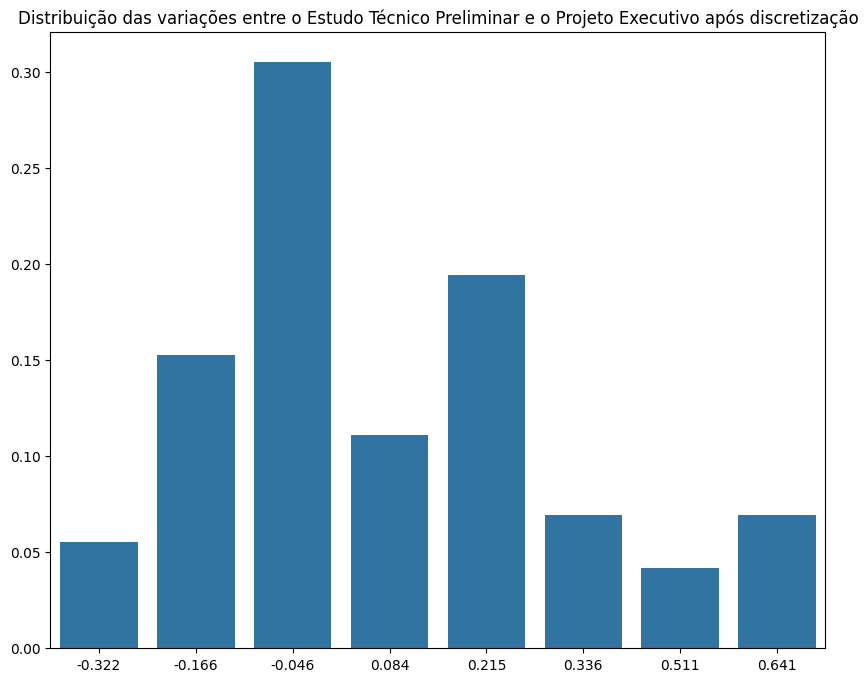

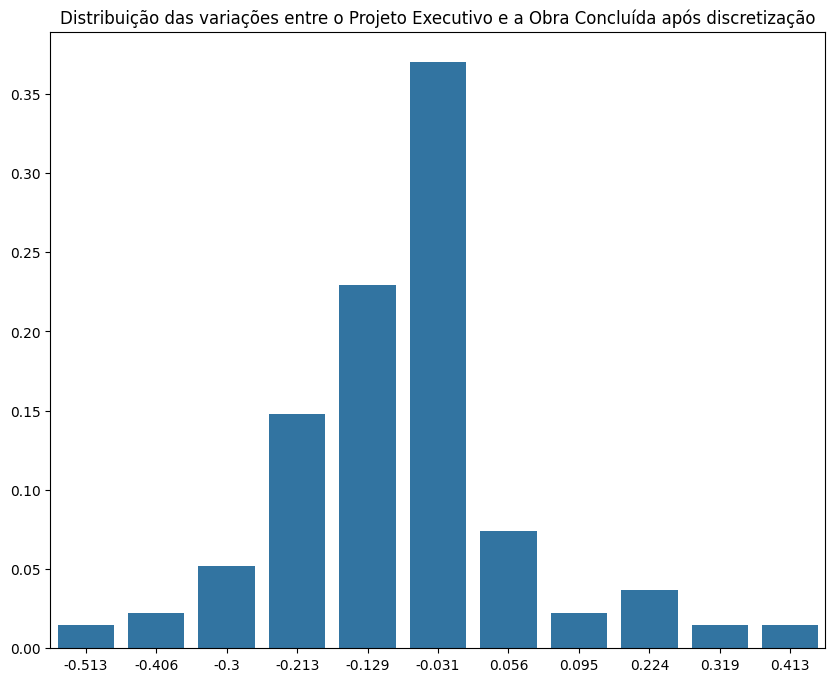

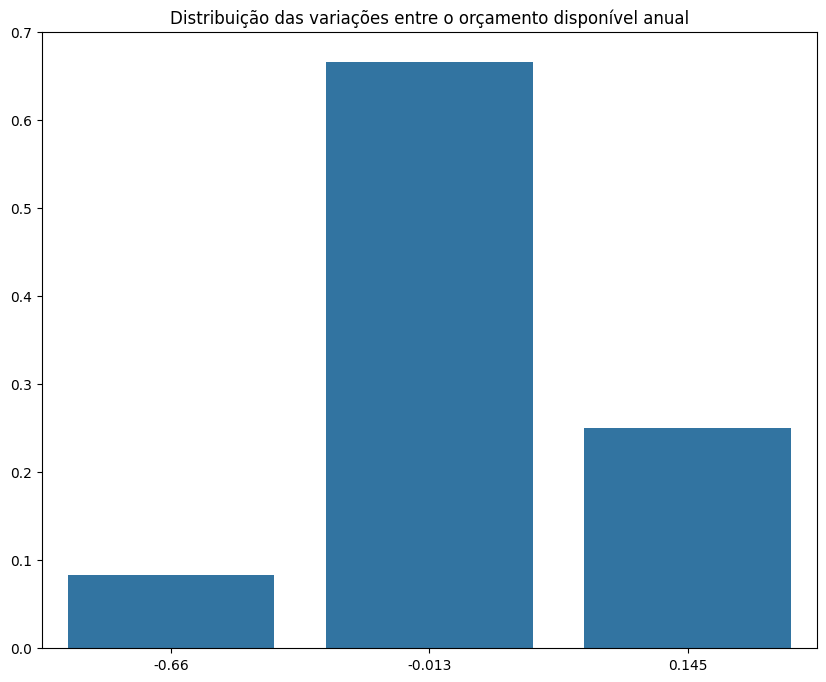

In [16]:
# Definindo a função que cria os bins
def create_bins(data):
    # Número de bins pela regra da raiz de n
    n = len(data)
    k = int(np.sqrt(n))

    # Define os limites dos bins
    counts, bin_edges = np.histogram(data, bins=k)
    probabilities = counts / counts.sum()

    bins_dict = {}

    for i in range(len(probabilities)):
        # Define o intervalo do bin
        lower, upper = bin_edges[i], bin_edges[i + 1]

        # Filtra os dados que estão dentro do intervalo
        in_bin = data[(data >= lower) & (data < upper)]  # include left, exclude right

        # Trata o caso em que não há dados no bin
        if len(in_bin) == 0:
            continue

        # Calcula a média dos dados dentro do bin
        media_bin = in_bin.mean().round(3)

        # Atribui ao dicionário
        bins_dict[media_bin] = probabilities[i]

    return bins_dict

# Discretizando os dados históricos
var_etp_prj = create_bins(df_var_etp_prj['VARIAÇÃO'])
var_prj_obr = create_bins(df_var_prj_obr['VARIAÇÃO'])
var_available_budget = create_bins(df_available_budget['VARIAÇÃO'])

var_dict = {
    'variações entre o Estudo Técnico Preliminar e o Projeto Executivo após discretização': var_etp_prj,
    'variações entre o Projeto Executivo e a Obra Concluída após discretização': var_prj_obr,
    'variações entre o orçamento disponível anual': var_available_budget
}

# Visualizando os bins criados
for key, value in var_dict.items():
    plt.figure(figsize=(10,8))
    sns.barplot(x=list(value.keys()), y=list(value.values()))
    plt.title(f'Distribuição das {key}')
    plt.show()
    print('')


## **4. Criação dos cenários com o método de Monte Carlo e escolha da solução com menor risco.**

### **4.1 Funções de implementação da simulação de Monte Carlo**

In [17]:
np.random.seed(123)

def cost_function(cost, var_dict, n_prj, expec_budget):
    """
    Calcula a função custo para uma carteira de projetos.
    """

    # Gera um único valor para 'delta_d'
    delta_d = np.random.choice(list(var_dict['variações entre o orçamento disponível anual']),
                1,
                p=list(var_dict['variações entre o orçamento disponível anual'].values()))[0]

    # Verificações iniciais
    if expec_budget == 0:
        raise ValueError("Erro: orçamento disponível estimado é zero.")
    if delta_d == -1:
        raise ValueError("Erro: a variação anual do orçamento disponível tem valor -1, o que causará divisão por zero.")

    cost_rate = 0
    for i in range(n_prj):
        # Gere um único valor para 'delta_p' e 'delta_o'
        delta_p = np.random.choice(list(var_dict['variações entre o Estudo Técnico Preliminar e o Projeto Executivo após discretização']),
                1,
                p=list(var_dict['variações entre o Estudo Técnico Preliminar e o Projeto Executivo após discretização'].values()))[0]
        delta_o = np.random.choice(list(var_dict['variações entre o Projeto Executivo e a Obra Concluída após discretização']),
                1,
                p=list(var_dict['variações entre o Projeto Executivo e a Obra Concluída após discretização'].values()))[0]

        if np.isnan(cost[i]):
            raise ValueError(f"Erro: 'estimativa' no índice {i} é NaN.")

        cost_rate += (cost[i] * (1 + delta_p) * (1 + delta_o))
    cost_rate = cost_rate/(expec_budget * (1 + delta_d))

    return cost_rate


def montecarlo(cost, var_dict, n_prj, expec_budget, n_rep, tolerance_interval):
    '''
    Gerencia as simulações e guarda os resultadps em uma lista
    '''
    # Lista para armazenar os resultados
    results = []
    # Executa a simulação de Monte Carlo
    for _ in range(n_rep):
        results.append(cost_function(cost, var_dict, n_prj, expec_budget))
    # Converte os resultados em um array para análise
    frame = np.array(results)
    meets_criteria = np.sum((frame >= tolerance_interval[0]) & (frame <= tolerance_interval[1])) / len(frame)

    return meets_criteria, frame

### **4.2 Acionamento da simulação de Monte Carlo**

Na próxima célula as funções acima serão aplicadas em todas as carteiras possíveis

In [19]:
df_meets_criteria = pd.DataFrame(columns=['ID', 'Meets Criteria %'])
frames = pd.DataFrame()

# Loop para ver qual carteira é a de menor risco orçamentário
for i in range (1, len(df_list) + 1):
    cost = df_list['VALOR ESTIMATIVA (R$)'].tolist()[:i]
    n_prj = len(cost)
    meets_criteria, frame = montecarlo(cost, var_dict, n_prj, expec_budget, n_rep, tolerance_interval)
    id = df_list.loc[i - 1, 'ID']
    newline = pd.DataFrame({'ID': id, 'Meets Criteria %': meets_criteria},index=[len(df_meets_criteria)])
    df_meets_criteria = pd.concat([df_meets_criteria,newline])
    print(f'{id}: {meets_criteria}')
    frames[f'Carteira {i}'] = frame.flatten()

<ipython-input-19-024392d8fca9>:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_meets_criteria = pd.concat([df_meets_criteria,newline])


2093: 0.0004
2096: 0.0096
2097: 0.046
2165: 0.0588
2101: 0.0616
2102: 0.0604
2103: 0.0592
2104: 0.0384
2106: 0.0196
2108: 0.0212
2109: 0.014
2110: 0.014
2113: 0.01
2114: 0.0012
2100: 0.0668
2132: 0.338
2134: 0.3884
2139: 0.5924
2140: 0.6188
2146: 0.6316
2155: 0.6964
2148: 0.7444
2149: 0.6412
2181: 0.2152
2150: 0.1688
2151: 0.1848
2152: 0.1552
2153: 0.1512
2180: 0.1024
2199: 0.078
2206: 0.0108
2207: 0.0
2208: 0.0
2213: 0.0


Agora será encontrada a carteira com maior $ r_{Budget} $, que, segundo o critério aqui adotado corresponde à de menor risco orçamentário.

In [20]:
# Encontrando o maior in_crit e os IDs associados
id_max_meets_criteria = df_meets_criteria['Meets Criteria %'].idxmax()
ids_associados = df_meets_criteria.loc[id_max_meets_criteria,'ID']
max_in_crit_orc = df_meets_criteria.loc[id_max_meets_criteria,'Meets Criteria %']
max_meets_criteria = df_list.loc[df_list['ID']==ids_associados]['PRIORIDADE'].values[0]

# Exibição da carteira de menor risco orçamentário
print(f'A carteira de projetos que minimiza o risco orçamentário corresponde'
       f'àquela cuja linha de corte se dá após o projeto de prioridade {max_meets_criteria}, cujo ID é o {ids_associados}.')

A carteira de projetos que minimiza o risco orçamentário correspondeàquela cuja linha de corte se dá após o projeto de prioridade 22, cujo ID é o 2148.


Visualizando o percentual de atendimento de $ \rho^{i} $ 's aos critérios de tolerância por cada projeto em um gráfico de dispersão.

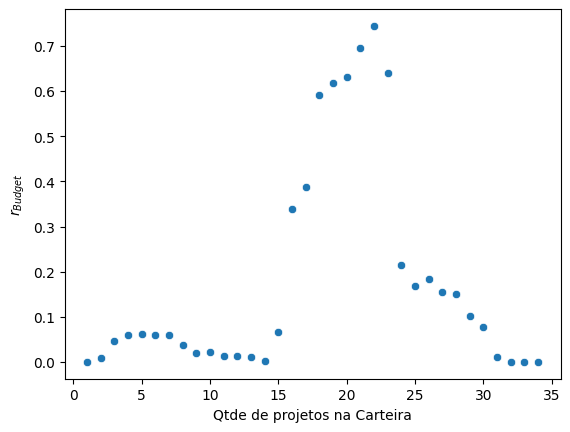

In [21]:
plt.Figure(figsize=(10,8))
sns.scatterplot(data=df_meets_criteria, x=1+df_meets_criteria.index,y='Meets Criteria %')
plt.ylabel(r'$ r_{Budget} $')
plt.xlabel('Qtde de projetos na Carteira')
plt.show()

No gráfico acima é possível visualizar como a carteira composta por 23 projetos é a que maximiza a probabilidade da razão entre o custo estimado e orçamento previsto se enquadrar dentro do intervalo de tolerância.
No entanto, será que existe diferença estatisticamente significante entre a carteira de 23 e a de 22 projetos, de tal forma que eventualmente fosse válido usar a solução de 22 projetos?

De modo a quantificar objetivamente essa semelhança entre soluções e responder a essa pergunta, será realizado, a partir dos  frames, um teste de hipótese Z para proporções.

## **5. Análise estatística da solução adotada**

O **teste Z** compara a proporção de cada carteira com a da melhor. Essa é a sua fórmula:

$$
Z = \frac{p_1 - p_2}{\sqrt{p_{\text{pool}}(1 - p_{\text{pool}})\left(\frac{1}{n} + \frac{1}{n}\right)}}
$$

Onde:

- $ p_1 = r_{Budget} $ (carteira ótima)
- $ p_2 = p_{\text{lower\_risk}} $ (melhor carteira)
- $ p_{\text{pool}} = \frac{p_1 + p_2}{2} $
- $ n $ = número de simulações

Esse teste aplicado a todas as carteiras viáveis responde à pergunta:
"A diferença entre cada carteira viável e a de menor risco orçamentário é estatisticamente significativa?"

Caso o p-valor correspondente ao Z de uma determinada carteira seja menor que o nível de significância (aqui será adotado 5%), a diferença é considerada estatisticamente significativa, descartando-se a hipótese nula de que as proporções são iguais.

Será calculado também o intervalo de confiança para as proporções de atendimento aos limites de tolerância para cada carteira, seguindo a expressão abaixo:

$$ IC = r_{Budget} +- z.\sqrt{\frac{p(1-p)}{n}} $$



Os p-valores encontrados são
Carteira 1     0.000000e+00
Carteira 2     0.000000e+00
Carteira 3     0.000000e+00
Carteira 4     0.000000e+00
Carteira 5     0.000000e+00
Carteira 6     0.000000e+00
Carteira 7     0.000000e+00
Carteira 8     0.000000e+00
Carteira 9     0.000000e+00
Carteira 10    0.000000e+00
Carteira 11    0.000000e+00
Carteira 12    0.000000e+00
Carteira 13    0.000000e+00
Carteira 14    0.000000e+00
Carteira 15    0.000000e+00
Carteira 16    0.000000e+00
Carteira 17    0.000000e+00
Carteira 18    0.000000e+00
Carteira 19    0.000000e+00
Carteira 20    0.000000e+00
Carteira 21    1.560133e-04
Carteira 22    1.000000e+00
Carteira 23    2.664535e-15
Carteira 24    0.000000e+00
Carteira 25    0.000000e+00
Carteira 26    0.000000e+00
Carteira 27    0.000000e+00
Carteira 28    0.000000e+00
Carteira 29    0.000000e+00
Carteira 30    0.000000e+00
Carteira 31    0.000000e+00
Carteira 32    0.000000e+00
Carteira 33    0.000000e+00
Carteira 34    0.000000e+00
Name: p-valor, dtyp

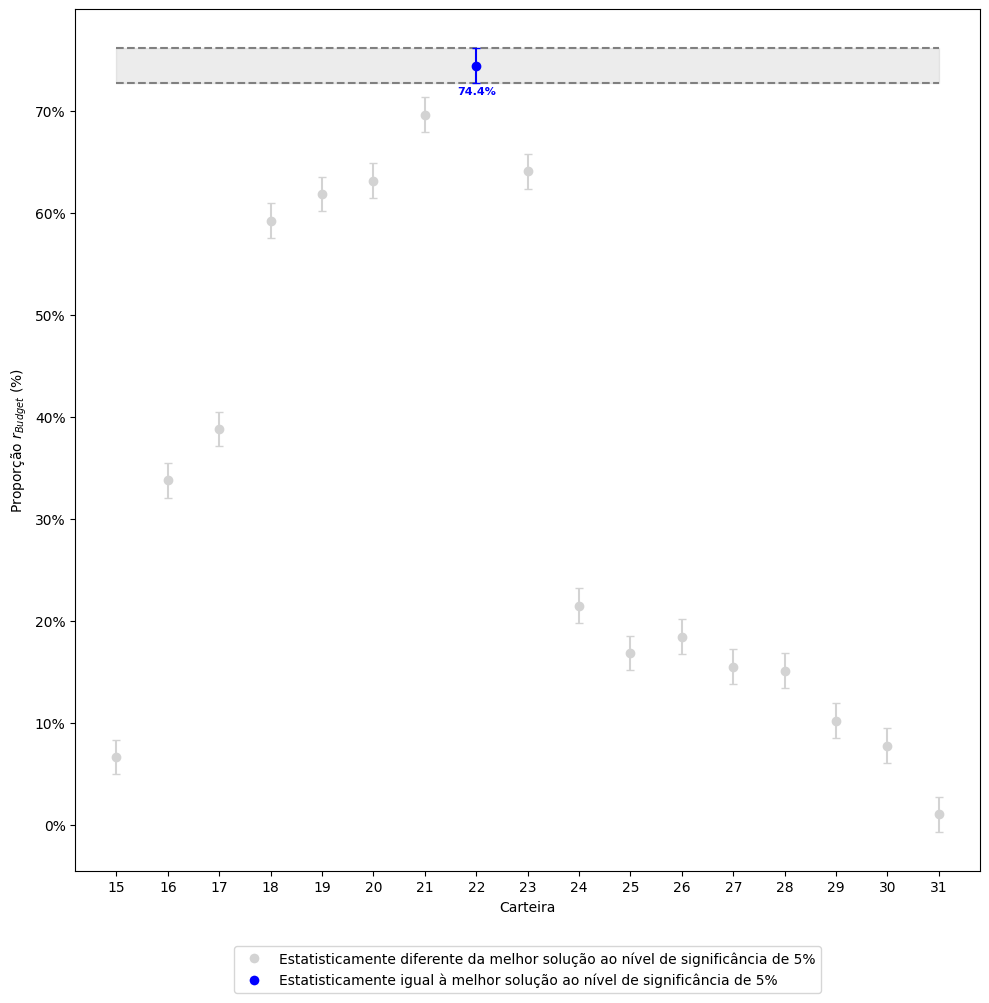


A Carteira com 22 projetos é a única estatisticamente viável como solução de menor risco orçamentário.


In [22]:
# Definindo o valor de z limite correspondente a um nível de significância de 5%
z = 1.96

# Função para calcular o teste Z entre as proporções
def calculate_z_test(frames, tolerance_interval):
    # Contar o número de observações entre os limites de tolerância
    count_in_range = ((frames > tolerance_interval[0]) & (frames < tolerance_interval[1])).sum(axis=0)
    n = frames.shape[0]
    proportion_in_range = count_in_range / n
    df = pd.DataFrame(proportion_in_range, columns=['rBudget'])

    # Melhor proporção
    p_lower_risk = df['rBudget'].max()

    # Pooled proportion
    df['pooled_proportion'] = (df['rBudget'] + p_lower_risk) / 2
    df['Teste Z'] = (p_lower_risk - df['rBudget']) / np.sqrt(df['pooled_proportion'] * (1 - df['pooled_proportion']) * (2 / n))

    # P-valor
    df['p-valor'] = 2 * (1 - norm.cdf(abs(df['Teste Z'])))

    return df, p_lower_risk, n

# Função que calcula o intervalo de confiança
def calculate_confidence_interval(df, z, p_lower_risk, n):
    delta_ci = z * np.sqrt(p_lower_risk * (1 - p_lower_risk) / n)
    df['inf_ci'] = df['rBudget'] - delta_ci
    df['sup_ci'] = df['rBudget'] + delta_ci
    df['errors'] = (df['sup_ci'] - df['inf_ci']) / 2
    return df

# Função para criar o gráfico de análise de similaridade entre as soluções
def plotar_grafico(df, z, study_range=8):
    significancia = {1.96: 0.05, 2.57: 0.01, 2.8: 0.005}

    max_index = df['rBudget'].idxmax()
    max_index = max_index.replace('Carteira ','')
    start_index = int(max(float(max_index) - study_range, 0))
    end_index = int(min(float(max_index) + study_range, len(df) - 1))

    df_subset = df.iloc[start_index:end_index + 1]
    x = df_subset.index
    x = [prt.replace('Carteira ','') for prt in x]
    y = df_subset['rBudget']
    errors = df_subset['errors']

    max_index_sup_ci = df_subset['sup_ci'].idxmax()
    max_index_inf_ci = df_subset['inf_ci'].idxmax()

    ref_inf = df_subset.loc[max_index_inf_ci, 'inf_ci']
    ref_sup = df_subset.loc[max_index_sup_ci, 'sup_ci']
    line_ref_inf = np.full(len(x), ref_inf)
    line_ref_sup = np.full(len(x), ref_sup)

    plt.figure(figsize=(10,10))
    plt.plot(x, line_ref_inf, color='gray', linestyle='--')
    plt.plot(x, line_ref_sup, color='gray', linestyle='--')
    plt.fill_between(x, line_ref_inf, line_ref_sup, color='gray', alpha=0.15)

    legend_handles = []
    legend_labels = []

    for i, (xi, yi, ei) in enumerate(zip(x, y, errors)):
        p_value = df_subset.iloc[i]['p-valor']
        if p_value > significancia[z]:
            color = 'blue'
            label = f'Estatisticamente igual à melhor solução ao nível de significância de {significancia[z]*100:.0f}%'
            plt.text(xi, yi - 0.025, f'{yi * 100:.1f}%', fontsize=8, ha='center', va='center', color='blue', fontweight='bold')
            if label not in legend_labels:
                legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8))
                legend_labels.append(label)
        else:
            color = 'lightgray'
            label = f'Estatisticamente diferente da melhor solução ao nível de significância de {significancia[z]*100:.0f}%'
            if label not in legend_labels:
                legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=8))
                legend_labels.append(label)

        plt.errorbar(xi, yi, yerr=ei, fmt='o', ecolor=color, color=color, capsize=3)

    plt.xlabel('Carteira')
    plt.ylabel('Proporção $r_{Budget}$ (%)')
    plt.gca().yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
    plt.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=1)
    plt.tight_layout()
    plt.show()

df_z, p_lower_risk, n = calculate_z_test(frames, tolerance_interval)
df_z = calculate_confidence_interval(df_z, z, p_lower_risk, n)
print('Os p-valores encontrados são')
print(df_z['p-valor'])
print('')
plotar_grafico(df_z, z)
print('')
significancia = {1.96: 0.05, 2.57: 0.01, 2.8: 0.005}
if (df_z['p-valor'] >= significancia[z]).sum() > 1:
    print(f'A Carteira com {max_meets_criteria} projetos não é a única estatisticamente viável'
          ' como solução de menor risco orçamentário.')
else:
    print(f'A Carteira com {max_meets_criteria} projetos é a única estatisticamente viável'
          ' como solução de menor risco orçamentário.')


No gráfico acima, os 'whiskers' representam os intervalos de confiança, sendo o intervalo de confiança da solução ótima destacado em cinza.
Com a análse realizada, foi possível concluir que a carteira composta pelos **22** projetos mais prioritários representa a solução com menor risco orçametário, atingindo os limites de tolerância em **75,1%** dos cenários.

## **6. Conclusões**

Sugere-se que o tomador de decisão opte pela seleção da carteira composta por 22 projetos, uma vez que esse portifólio foi é o que possui maior probabilidade de atender aos critérios de tolerância pré-definidos.

O Método de Monte Carlo mostrou-se uma ferramenta eficaz para otimizar carteiras de projetos no contexto apresentado simulando cenários com base nas probabilidades verificadas ao longo do tempo.

Os resultados indicaram a solução de menor risco orçamentário, considerando o limite de tolerância inicialmente definido. Além de apontar qual carteira é a ótima, o método quantifica o risco apresentando a probabilidade de atendimento dos critérios de tolerância.

Pode ser aplicado, com os devidos ajustes, em qualquer organização ou processo que lide com incertezas.